In [3]:
%matplotlib inline

In [4]:
import os, sys, threading

import numpy as np
import tensorflow as tf

import keras
from keras.utils import multi_gpu_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.layers.core import RepeatVector, Permute
from keras.models import Model
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, merge, concatenate
from keras.initializers import TruncatedNormal
from keras.optimizers import RMSprop, adam

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave

import matplotlib.pyplot as plt

/Users/fadhil/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
# Helper function

def batch_apply(ndarray, func, *args, **kwargs):
    batch = []
    for sample in ndarray:
        batch.append(func(sample, *args, **kwargs))
    return np.array(batch)

In [6]:
inception = InceptionResNetV2(weights='imagenet', include_top=True)
inception.graph = tf.get_default_graph()

In [7]:
def create_inception_embedding(grayscaled_rgb):
    with inception.graph.as_default():
        embed = inception.predict(grayscaled_rgb)
    return embed

In [8]:
with tf.device('/cpu:0'):
    #Inputs
    embed_input = Input(shape=(1000,))
    encoder_input = Input(shape=(256, 256, 1,))
    
    #Encoder
    encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2,
                            bias_initializer=TruncatedNormal(mean=0.0, stddev=0.05))(encoder_input)
    encoder_output = Conv2D(128, (3,3), activation='relu', padding='same',
                            bias_initializer=TruncatedNormal(mean=0.0, stddev=0.05))(encoder_output)
    encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2,
                            bias_initializer=TruncatedNormal(mean=0.0, stddev=0.05))(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same',
                            bias_initializer=TruncatedNormal(mean=0.0, stddev=0.05))(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2,
                            bias_initializer=TruncatedNormal(mean=0.0, stddev=0.05))(encoder_output)
    encoder_output = Conv2D(512, (3,3), activation='relu', padding='same',
                            bias_initializer=TruncatedNormal(mean=0.0, stddev=0.05))(encoder_output)
    encoder_output = Conv2D(512, (3,3), activation='relu', padding='same',
                            bias_initializer=TruncatedNormal(mean=0.0, stddev=0.05))(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same',
                            bias_initializer=TruncatedNormal(mean=0.0, stddev=0.05))(encoder_output)
    
    #Fusion
    fusion_output = RepeatVector(32 * 32)(embed_input) 
    fusion_output = Reshape(([32, 32, 1000]))(fusion_output)
    fusion_output = concatenate([encoder_output, fusion_output], axis=3) 
    fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same',
                            bias_initializer=TruncatedNormal(mean=0.0, stddev=0.05))(fusion_output)
    
    #Decoder
    decoder_output = Conv2D(128, (3,3), activation='relu', padding='same',
                            bias_initializer=TruncatedNormal(mean=0.0, stddev=0.05))(fusion_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    decoder_output = Conv2D(64, (3,3), activation='relu', padding='same',
                            bias_initializer=TruncatedNormal(mean=0.0, stddev=0.05))(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    decoder_output = Conv2D(32, (3,3), activation='relu', padding='same',
                            bias_initializer=TruncatedNormal(mean=0.0, stddev=0.05))(decoder_output)
    decoder_output = Conv2D(16, (3,3), activation='relu', padding='same',
                            bias_initializer=TruncatedNormal(mean=0.0, stddev=0.05))(decoder_output)
    decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same',
                            bias_initializer=TruncatedNormal(mean=0.0, stddev=0.05))(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    
    model = Model(inputs=[encoder_input, embed_input], outputs=decoder_output)

In [9]:
datagen = ImageDataGenerator(shear_range=0.2, zoom_range=0.2, rotation_range=20, horizontal_flip=True)

In [10]:
def process_images(rgb, input_size=(256, 256, 3), embed_size=(299, 299, 3)):
    # Resize for embed and Convert to grayscale
    gray = gray2rgb(rgb2gray(rgb))
    gray = batch_apply(gray, resize, embed_size, mode='constant')
    # Zero-Center [-1, 1]
    gray = gray * 2 - 1
    # Generate embeddings
    embed = create_inception_embedding(gray)
    
    # Resize to input size of model
    re_batch = batch_apply(rgb, resize, input_size, mode='constant')
    # RGB => L*a*b*
    re_batch = batch_apply(re_batch, rgb2lab)
    
    # Extract L* into X, zero-center and normalize
    X_batch = re_batch[:,:,:,0]
    X_batch = X_batch/50 - 1
    X_batch = X_batch.reshape(X_batch.shape+(1,))
    
    # Extract a*b* into Y and normalize. Already zero-centered.
    Y_batch = re_batch[:,:,:,1:]
    Y_batch = Y_batch/128
    
    return [X_batch, embed], Y_batch

In [11]:
def image_a_b_gen(images, batch_size):
    while True:
        for batch in datagen.flow(images, batch_size=batch_size):
            yield process_images(batch)

In [12]:
def serialize_records(X, writer, batch_size):
    [X_batch, features], Y_batch = process_images(X)
    
    for j, (img_l, embed, y) in enumerate(zip(X_batch, features, Y_batch)):

        example_dict = {
            'image_l': tf.train.Feature(float_list=tf.train.FloatList(value=img_l.flatten())),
            'image_ab': tf.train.Feature(float_list=tf.train.FloatList(value=y.flatten())),
            'image_features' : tf.train.Feature(float_list=tf.train.FloatList(value=embed.flatten()))
        }
        example_features = tf.train.Features(feature=example_dict)
        example = tf.train.Example(features=example_features)
        writer.write(example.SerializeToString())

In [13]:
def img_to_tf_records(files, _type, batch_size=10):
    filename = _type+'_images.tfrecord'
    if os.path.exists('/tfrecord/'+filename):
        os.remove('/tfrecord/'+filename)
    
    options = tf.python_io.TFRecordOptions(tf.python_io.TFRecordCompressionType.ZLIB)
    writer = tf.python_io.TFRecordWriter(filename, options)

    X_buffer = []
    for i, file in enumerate(files):
        X_buffer.append(file)
        if len(X_buffer) >= batch_size:
            X_buffer = np.array(X_buffer)
            serialize_records(X_buffer, writer, batch_size)
            del X_buffer
            X_buffer = []
            print("Done %d / %d images" % (i+1, len(files)))

    if len(X_buffer) != 0:
        X_buffer = np.array(X_buffer)
        serialize_records(X_buffer, writer, batch_size)
        del X_buffer

    print("Done %d / %d images" % (len(files), len(files)))
    print("Finished preprocessed data to TFRecoeds")
    writer.close()

In [14]:
def construct_dataset(path_to_record, batch_size, sess):
    def parse_record(serialized_example):
        features = tf.parse_single_example(serialized_example,
                                          features={
                                              'image_l': tf.FixedLenFeature([IMG_SIZE, IMG_SIZE, 1], tf.float32),
                                              'image_ab': tf.FixedLenFeature([IMG_SIZE, IMG_SIZE, 2], tf.float32),
                                              'image_features': tf.FixedLenFeature([1000, ], tf.float32)
                                          })
        l, ab, embed = features['image_l'], features['image_ab'], features['image_features']
        return l, ab, embed
    
    dataset = tfdata.TFRecordDataset([path_to_record], 'ZLIB')
    dataset = dataset.map(parse_record, num_parallel_calls=2)
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size)
    dataset = dataset.shuffle(buffer_size=5)
    iterator = dataset.make_initializable_iterator()
    
    sess.run(iterator.initializer)
    next_batch = iterator.get_next()
    
    return dataset, next_batch

In [15]:
def batch_generator(tfrecord_filepath, batch_size):
    with tf.Session() as train_gen_session:
        dataset, next_batch = construct_dataset(tfrecord_filepath, batch_size, train_gen_session)

        while True:
            try:
                l, ab, features = train_gen_session.run(next_batch)
                yield([l, features], ab)
            except:
                iterator = dataset.make_initializable_iterator()
                train_gen_session.run(iterator.initializer)
                next_batch = iterator.get_next()

                l, ab, features = train_gen_session.run(next_batch)
                yield([l, features], ab)

In [16]:
DATASET = '../Deep-Image-Colorization/tiny-imagenet-200/test/images/'

training_files, testing_files = train_test_split(shuffle(os.listdir(DATASET)), test_size=0.15)
# training_files = ['test_2.JPEG']
# testing_files = ['sample.JPEG']

def getImages(DATASET, filelist, transform_size=(299, 299, 3)):
    """Reads JPEG filelist from DATASET and returns float represtation of RGB [0.0, 1.0]"""
    img_list = []
    for i,filename in enumerate(filelist):
        if i < 100: 
            if 'JPEG' in filename:
                image_in = img_to_array(load_img(DATASET + filename))
#                 image_in = img_to_array(load_img(filename))

                image_in = image_in/255

                if transform_size is not None:
                    image_in = resize(image_in, transform_size, mode='reflect')

                img_list.append(image_in)
    img_list = np.array(img_list)
    
    return img_list

In [17]:
model.compile(optimizer=RMSprop(lr=1e-3), loss='mse')

In [96]:
training_set = getImages(DATASET, training_files)

In [99]:
train_size = int(len(training_set)*0.85)
train_images = training_set[:train_size]
val_images = training_set[train_size:]
val_steps = (len(val_images)//10)

In [108]:
img_to_tf_records(train_images, 'train')

Done 10 / 85 images
Done 20 / 85 images
Done 30 / 85 images
Done 40 / 85 images
Done 50 / 85 images
Done 60 / 85 images
Done 70 / 85 images
Done 80 / 85 images
Done 85 / 85 images
Finished preprocessed data to TFRecoeds


In [115]:
def train(model, training_files, batch_size=10, epochs=30, steps_per_epoch=10):
    training_set = getImages(DATASET, training_files)
    train_size = int(len(training_set)*0.85)
#     train_size = int(len(training_set)*1)
    train_images = training_set[:train_size]
    val_images = training_set[train_size:]
    val_steps = (len(val_images)//batch_size)
    img_to_tf_records(train_images, 'train')
    img_to_tf_records(val_images, 'val')
    print("Training samples:", train_size, "Validation samples:", len(val_images))

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=15, verbose=1, min_delta=1e-5),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, cooldown=0, verbose=1, min_lr=1e-8),
        ModelCheckpoint(monitor='val_loss', filepath='model_output/colorize.hdf5', verbose=1,
                         save_best_only=True, save_weights_only=True, mode='auto'),
        TensorBoard(log_dir='./logs', histogram_freq=10, batch_size=20, write_graph=True, write_grads=True,
                    write_images=False, embeddings_freq=0)
    ]

#     model.fit_generator(image_a_b_gen(train_images, batch_size), epochs=epochs, steps_per_epoch=steps_per_epoch,
#                         verbose=1)
    
    model.fit_generator(batch_generator('./tfrecord/train_images.tfrecord', batch_size), epochs=epochs, steps_per_epoch=steps_per_epoch,
                        verbose=1, callbacks=callbacks, validation_data=batch_generator('./tfrecord/val_images.tfrecord', batch_size),
                       validation_steps=1)

In [18]:
def test(model, testing_files, save_actual=False, save_gray=False):
    test_images = getImages(DATASET, testing_files)
    model.load_weights(filepath='model_output/colorize_ref.hdf5', by_name=True)

    print('Preprocessing Images')
    X_test, Y_test = process_images(test_images)
    
    print('Predicting')
    # Test model
    output = model.predict(X_test)
    
    # Rescale a*b* back. [-1.0, 1.0] => [-128.0, 128.0]
    output = output * 128
    Y_test = Y_test * 128

    # Output colorizations
    for i in range(len(output)):
        name = testing_files[i].split(".")[0]
        print('Saving '+str(i)+"th image " + name + "_*.png")
        
        lightness = X_test[0][i][:,:,0]
        
        #Rescale L* back. [-1.0, 1.0] => [0.0, 100.0]
        lightness = (lightness + 1) * 50
        
        predicted = np.zeros((256, 256, 3))
        predicted[:,:,0] = lightness
        predicted[:,:,1:] = output[i]
        plt.imsave("result/predicted/" + name + ".jpeg", lab2rgb(predicted))
        
        if save_gray:
            bnw = np.zeros((256, 256, 3))
            bnw[:,:,0] = lightness
            plt.imsave("result/bnw/" + name + ".jpeg", lab2rgb(bnw))
        
        if save_actual:
            actual = np.zeros((256, 256, 3))
            actual[:,:,0] = lightness
            actual[:,:,1:] = Y_test[i]
            plt.imsave("result/actual/" + name + ".jpeg", lab2rgb(actual))

In [ ]:
train(model, training_files, epochs=100)

Done 10 / 85 images
Done 20 / 85 images
Done 30 / 85 images
Done 40 / 85 images
Done 50 / 85 images
Done 60 / 85 images
Done 70 / 85 images
Done 80 / 85 images
Done 85 / 85 images
Finished preprocessed data to TFRecoeds
Done 10 / 15 images
Done 15 / 15 images
Finished preprocessed data to TFRecoeds
Training samples: 85 Validation samples: 15


In [19]:
test(model, testing_files, True, True)

Preprocessing Images
Predicting
Saving 0th image test_2247_*.png
Saving 1th image test_4122_*.png
Saving 2th image test_1177_*.png
Saving 3th image test_6389_*.png
Saving 4th image test_3858_*.png
Saving 5th image test_7383_*.png
Saving 6th image test_8974_*.png
Saving 7th image test_5314_*.png
Saving 8th image test_2673_*.png
Saving 9th image test_6375_*.png
Saving 10th image test_2021_*.png
Saving 11th image test_1937_*.png
Saving 12th image test_2184_*.png
Saving 13th image test_8991_*.png
Saving 14th image test_3810_*.png
Saving 15th image test_5798_*.png
Saving 16th image test_7968_*.png
Saving 17th image test_7245_*.png
Saving 18th image test_6720_*.png
Saving 19th image test_8631_*.png
Saving 20th image test_7646_*.png
Saving 21th image test_83_*.png
Saving 22th image test_9668_*.png
Saving 23th image test_4645_*.png
Saving 24th image test_6580_*.png
Saving 25th image test_2139_*.png
Saving 26th image test_9988_*.png
Saving 27th image test_5234_*.png
Saving 28th image test_8440_

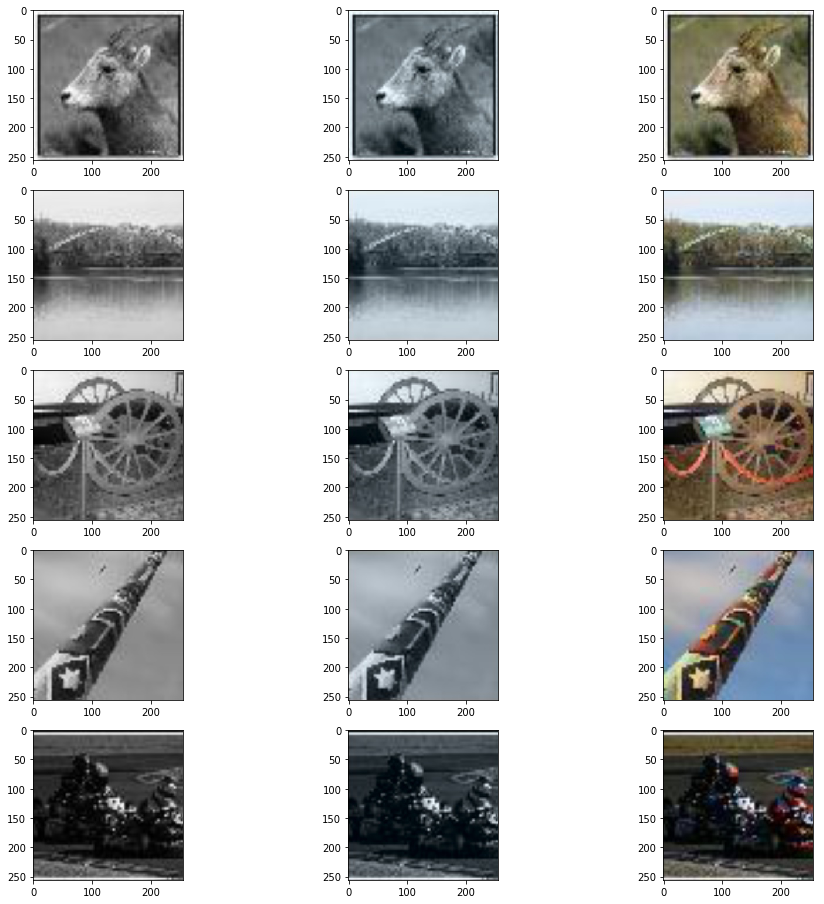

In [21]:
filelist = shuffle(os.listdir('result/predicted/'))
filelist = filelist[:5]

fig, ax = plt.subplots(5, 3, figsize=(16,16))
row = 0
for filename in filelist:
    folder = 'result/bnw/'
    image_in = img_to_array(load_img(folder + filename))
    image_in = image_in/255
    ax[row,0].imshow(image_in)
    
    folder = 'result/predicted/'
    image_in = img_to_array(load_img(folder + filename))
    image_in = image_in/255
    ax[row,1].imshow(image_in)
    
    folder = 'result/actual/'
    image_in = img_to_array(load_img(folder + filename))
    image_in = image_in/255
    ax[row,2].imshow(image_in)
    
    row += 1